RF Accuracy: 0.8791208791208791
[[43  6]
 [ 5 37]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        49
           1       0.86      0.88      0.87        42

    accuracy                           0.88        91
   macro avg       0.88      0.88      0.88        91
weighted avg       0.88      0.88      0.88        91

Epoch 1/30


/Users/rishimane/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/rishimane/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


19/19 - 0s - 22ms/step - accuracy: 0.5842 - loss: 0.7659 - val_accuracy: 0.4091 - val_loss: 0.8288
Epoch 2/30
19/19 - 0s - 2ms/step - accuracy: 0.7000 - loss: 0.7189 - val_accuracy: 0.7273 - val_loss: 0.7457
Epoch 3/30
19/19 - 0s - 2ms/step - accuracy: 0.7895 - loss: 0.6746 - val_accuracy: 0.8636 - val_loss: 0.6637
Epoch 4/30
19/19 - 0s - 2ms/step - accuracy: 0.8105 - loss: 0.6246 - val_accuracy: 0.8636 - val_loss: 0.6213
Epoch 5/30
19/19 - 0s - 2ms/step - accuracy: 0.8158 - loss: 0.5871 - val_accuracy: 0.8636 - val_loss: 0.5847
Epoch 6/30
19/19 - 0s - 2ms/step - accuracy: 0.8211 - loss: 0.5533 - val_accuracy: 0.8636 - val_loss: 0.5242
Epoch 7/30
19/19 - 0s - 2ms/step - accuracy: 0.8368 - loss: 0.5226 - val_accuracy: 0.8636 - val_loss: 0.5032
Epoch 8/30
19/19 - 0s - 2ms/step - accuracy: 0.8316 - loss: 0.5010 - val_accuracy: 0.9091 - val_loss: 0.4511
Epoch 9/30
19/19 - 0s - 2ms/step - accuracy: 0.8316 - loss: 0.4876 - val_accuracy: 0.8636 - val_loss: 0.4519
Epoch 10/30
19/19 - 0s - 2ms/

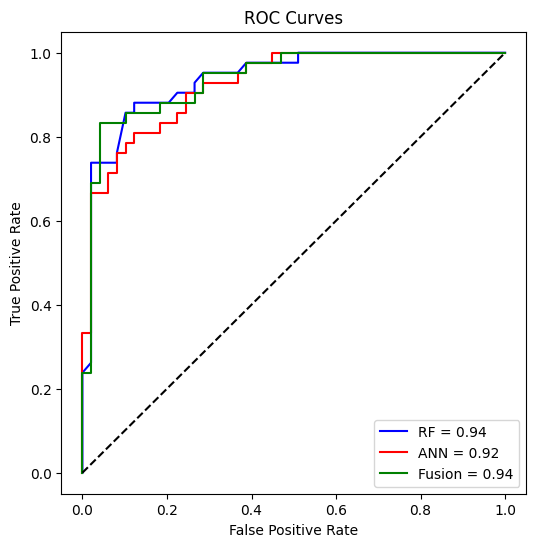

In [3]:
# ==============================
# Heart Disease Binary Classification + Fusion
# ==============================

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD

# ------------------------------
# Load dataset
# ------------------------------
dataset = pd.read_csv("./binary classification.csv")

# Features (0-12), Target (13)
x = dataset.iloc[:, 0:13].values
y = dataset.iloc[:, 13].values

# Train-test split (70:30 ratio here; change test_size=0.2 for 80:20)
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, shuffle=True, stratify=y, random_state=42
)

# ------------------------------
# Random Forest
# ------------------------------
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)
proba_rf = model_rf.predict_proba(X_test)

print("RF Accuracy:", metrics.accuracy_score(y_test, y_pred_rf))
print(metrics.confusion_matrix(y_test, y_pred_rf))
print(metrics.classification_report(y_test, y_pred_rf))

fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, proba_rf[:,1])
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)

# ------------------------------
# ANN
# ------------------------------
scaler = MinMaxScaler()
scaled_X_train_ann = scaler.fit_transform(X_train)
scaled_X_test_ann = scaler.transform(X_test)

model_ann = Sequential()
model_ann.add(Dense(8, input_dim=13, activation='relu', kernel_regularizer=l2(0.01)))
model_ann.add(Dense(1, activation='sigmoid'))

sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_ann.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

history = model_ann.fit(
    scaled_X_train_ann, y_train,
    validation_split=0.1,
    batch_size=10, epochs=30, shuffle=True, verbose=2
)

proba_ann = model_ann.predict(scaled_X_test_ann, batch_size=5, verbose=0)
y_pred_ann = np.round(proba_ann).astype(int).flatten()

print("ANN Accuracy:", metrics.accuracy_score(y_test, y_pred_ann))
print(metrics.confusion_matrix(y_test, y_pred_ann))
print(metrics.classification_report(y_test, y_pred_ann))

fpr_ann, tpr_ann, _ = metrics.roc_curve(y_test, proba_ann)
roc_auc_ann = metrics.auc(fpr_ann, tpr_ann)

# ------------------------------
# Weighted Fusion (RF + ANN)
# ------------------------------
best_acc = 0
best_p = None

for p in np.arange(0.05, 1.0, 0.05):
    q = 1 - p
    mixed = proba_rf[:,1]*p + proba_ann[:,0]*q
    rounded_mixed = (mixed >= 0.5).astype(int)
    acc = metrics.accuracy_score(y_test, rounded_mixed)
    if acc > best_acc:
        best_acc, best_p = acc, p
    print(f"Fusion Acc={acc:.4f} (p={p:.2f}, q={q:.2f})")

print("Best Fusion Accuracy:", best_acc, "at p=", best_p, "q=", 1-best_p)

# Final fusion using best weights
p = best_p
q = 1 - p
mixed = proba_rf[:,1]*p + proba_ann[:,0]*q
rounded_mixed = (mixed >= 0.5).astype(int)

print("Fusion Confusion Matrix:\n", metrics.confusion_matrix(y_test, rounded_mixed))
print(metrics.classification_report(y_test, rounded_mixed))

fpr_fusion, tpr_fusion, _ = metrics.roc_curve(y_test, mixed)
roc_auc_fusion = metrics.auc(fpr_fusion, tpr_fusion)

# ------------------------------
# Plot ROC Curves
# ------------------------------
plt.figure(figsize=(6,6))
plt.title('ROC Curves')
plt.plot(fpr_rf, tpr_rf, 'b', label=f'RF = {roc_auc_rf:.2f}')
plt.plot(fpr_ann, tpr_ann, 'r', label=f'ANN = {roc_auc_ann:.2f}')
plt.plot(fpr_fusion, tpr_fusion, 'g', label=f'Fusion = {roc_auc_fusion:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
